<a href="https://colab.research.google.com/github/manikd31/NLP/blob/master/NLP_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mount Google Drive to collect dataset as CSV file
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Import basic libraries for Python
import matplotlib.pyplot as plt
import matplotlib._color_data as coldat
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# Read housing.csv and display top-10 records in the data-set
dataset = pd.read_csv('/content/drive/My Drive/housing.csv')
dataset = dataset.dropna()
col_names = list(dataset.columns)

print("The first ten records of the dataset are:")
dataset.head(10)

The first ten records of the dataset are:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [0]:
# Get inputs and outputs from data-set dataframe
dataset = dataset.drop(columns='ocean_proximity')
X = dataset.loc[:, 'longitude':'median_income']
Y = dataset['median_house_value']

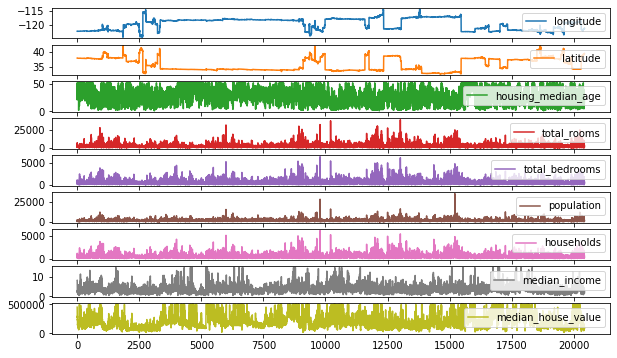

In [73]:
# Graph of subplots of all features in the entire data-set

fig, ax = plt.subplots(dataset.shape[1], figsize=(10, 6))

x = np.transpose(dataset.values)

colors = list(coldat.TABLEAU_COLORS.values())

for i in range(x.shape[0]):
    ax[i].plot(range(x.shape[1]), x[i], color=colors[i], label=col_names[i])
    ax[i].legend(loc='upper right')

plt.show()


# Another way of plotting the graph is using the DatFrame object directly

# df = pd.DataFrame(dataset)
# df.plot(subplots=True, figsize=(10, 6), legend=True)
# plt.show()


In [74]:
# Split train and test data and convert to numpy arrays
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2003)

x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

print(x_train_np.shape)
print(y_train_np.shape)
print(x_test_np.shape)
print(y_test_np.shape)

(14303, 8)
(14303,)
(6130, 8)
(6130,)


In [0]:
# Import essential libraries for PyTorch
import torch
import torch.nn as nn
from torch.nn import Conv1d, MaxPool1d, Flatten, Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD, Adam, ASGD
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [0]:
# Create a class to use as a helper to create neural network models
class ConvNet(torch.nn.Module):

    # Initialize parameters for the CNN model
    def __init__(self, in_ch, out_ch, batch_size, kernel_size):
        super(ConvNet, self).__init__()

        self.batch_size = batch_size
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = 1

        self.conv1 = Conv1d(in_ch, batch_size, kernel_size)

        self.pool1 = MaxPool1d(kernel_size)

        self.conv2 = Conv1d(batch_size, 128, kernel_size)

        self.flatten = Flatten()

        self.fc1 = Linear(128, 64)

        self.predictions = Linear(64, out_ch)

    # Feedforward data into the CNN model using this method
    def forward(self, inputs):
        inputs = inputs.reshape((self.batch_size, self.in_ch, 1))

        x = relu(self.conv1(inputs))
        x = self.pool1(x)
        x = relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc1(x)
        output = self.predictions(x)

        return output

In [0]:
# Should return the average l1-loss and average r2-score for the data set
def compute_performance(model, data, train=False, optimizer=None):
    loss_metric = L1Loss()
    score_metric = R2Score()

    avg_loss = 0
    avg_score = 0
    count = 0

    # Calculate loss and score metrics for each instance in the data-set
    for inp, outp in iter(data):
        y_pred = model.forward(inp)

        loss = loss_metric(y_pred, outp)
        score_metric.update([y_pred, outp])
        score = score_metric.compute()

        # Check if weights need to be trained
        if(train):
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss += loss.item()
        avg_score += score
        count += 1

    avg_loss /= count
    avg_score /= count

    return avg_loss, avg_score

In [0]:
# Initialize CNN model hyperparameters
batches = [32, 64, 128]
kernel_size = 1
max_epochs = 20
lr = 1e-5

In [0]:
# Create dictionaries to store values of losses and scores for
# all possible combinations of hyperparameters for comparison
all_losses = dict()
all_scores = dict()
all_times = dict()

In [80]:
#
# This block trains the ConvNet model using the SGD optimizer in PyTorch
#

in_data = torch.from_numpy(x_train_np).cuda().float()
out_data = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

test_in_data = torch.from_numpy(x_test_np).cuda().float()
test_out_data = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

# optimizer = SGD(cnn_model.parameters(), lr=lr)
# optimizer = ASGD(cnn_model.parameters(), lr=lr)
# optimizer = Adam(cnn_model.parameters(), lr=lr)

tensor = TensorDataset(in_data, out_data)

# Start tracking time
start_time = time.time()

# Create dictionaries to store losses and scores for current combination of hyperparameters
losses = dict()
scores = dict()

# Check for each possible batch_size in [32, 64, 128]
for batch_size in batches:

    start = time.time()
    # Create CNN model with the given batch_size
    cnn_model = ConvNet(X.shape[1], 1, batch_size, kernel_size)
    cnn_model.cuda()

    # Create an optimizer using the current model's parameters
    optimizer = SGD(cnn_model.parameters(), lr=lr)
    # optimizer = ASGD(cnn_model.parameters(), lr=lr)
    # optimizer = Adam(cnn_model.parameters(), lr=lr)
    
    loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

    # Create lists to store current batch_size losses and scores
    _losses = []
    _scores = []

    print('-'*20)
    print("Batch Size : " + str(batch_size))
    for epoch in range(max_epochs):
        loss, score = compute_performance(cnn_model, loader, train=True, optimizer=optimizer)
        _losses.append(loss)
        _scores.append(score)
        
        if(epoch+1 == max_epochs):
            print("Training Epoch {}\n\tL1-Loss : {}\n\tR2-score : {}".format(epoch+1, loss, score))

    test_loss, test_score = compute_performance(cnn_model, loader, train=False, optimizer=optimizer)

    key_batchsize = str(batch_size)
    key_optim = 'SGD'

    losses[key_batchsize] = _losses
    scores[key_batchsize] = _scores

    print()
    print("Testing Loss and Scores")
    print()
    print("L1-Loss = {}\nR2-Score = {}".format(test_loss, test_score))

    stop = time.time()

    el_time = round(stop - start, 3)
    print()
    print("Time elapsed : {}".format(el_time))

    # print("...Done...")
    print('-'*20)
    print()

all_losses[key_optim] = losses
all_scores[key_optim] = scores

stop_time = time.time()

elapsed_time = round(stop_time - start_time, 3)

print()
print("Total Time elapsed : " + str(elapsed_time))
all_times[key_optim] = elapsed_time

--------------------
Batch Size : 32
Training Epoch 100
	L1-Loss : 75742.56382251962
	R2-score : 0.23562357626110578

Testing Loss and Scores

L1-Loss = 75763.03109234865
R2-Score = 0.2201877646892559
--------------------

--------------------
Batch Size : 64
Training Epoch 100
	L1-Loss : 76986.30882146861
	R2-score : 0.21874218016494687

Testing Loss and Scores

L1-Loss = 69629.49329105942
R2-Score = 0.3731528436649739
--------------------

--------------------
Batch Size : 128
Training Epoch 100
	L1-Loss : 77849.62521114865
	R2-score : 0.21006066322913278

Testing Loss and Scores

L1-Loss = 73915.14984515766
R2-Score = 0.32572683115923917
--------------------


Time elapsed : 172.92


In [84]:
#
# This block trains the ConvNet model using the ASGD optimizer in PyTorch
#

in_data = torch.from_numpy(x_train_np).cuda().float()
out_data = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

test_in_data = torch.from_numpy(x_test_np).cuda().float()
test_out_data = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

# optimizer = SGD(cnn_model.parameters(), lr=lr)
# optimizer = ASGD(cnn_model.parameters(), lr=lr)
# optimizer = Adam(cnn_model.parameters(), lr=lr)

tensor = TensorDataset(in_data, out_data)

# Start tracking time
start_time = time.time()

# Create dictionaries to store losses and scores for current combination of hyperparameters
losses = dict()
scores = dict()

# Check for each possible batch_size in [32, 64, 128]
for batch_size in batches:
    # Create CNN model with the given batch_size
    cnn_model = ConvNet(X.shape[1], 1, batch_size, kernel_size)
    cnn_model.cuda()

    # Create an optimizer using the current model's parameters
    # optimizer = SGD(cnn_model.parameters(), lr=lr)
    optimizer = ASGD(cnn_model.parameters(), lr=lr)
    # optimizer = Adam(cnn_model.parameters(), lr=lr)
    
    loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

    # Create lists to store current batch_size losses and scores
    _losses = []
    _scores = []

    print('-'*20)
    print("Batch Size : " + str(batch_size))
    for epoch in range(max_epochs):
        loss, score = compute_performance(cnn_model, loader, train=True, optimizer=optimizer)
        _losses.append(loss)
        _scores.append(score)
        
        if(epoch+1 == max_epochs):
            print("Training Epoch {}\n\tL1-Loss : {}\n\tR2-score : {}".format(epoch+1, loss, score))

    test_loss, test_score = compute_performance(cnn_model, loader, train=False, optimizer=optimizer)

    key_batchsize = str(batch_size)
    key_optim = 'ASGD'

    losses[key_batchsize] = _losses
    scores[key_batchsize] = _scores

    print()
    print("Testing Loss and Scores")
    print()
    print("L1-Loss = {}\nR2-Score = {}".format(test_loss, test_score))

    # print("...Done...")
    print('-'*20)
    print()

all_losses[key_optim] = losses
all_scores[key_optim] = scores

stop_time = time.time()

elapsed_time = round(stop_time - start_time, 3)

print()
print("Time elapsed : " + str(elapsed_time))
all_times[key_optim] = elapsed_time

--------------------
Batch Size : 32
Training Epoch 100
	L1-Loss : 75763.80195487668
	R2-score : 0.2565758547122161

Testing Loss and Scores

L1-Loss = 84933.20486792321
R2-Score = 0.08063606880309497
--------------------

--------------------
Batch Size : 64
Training Epoch 100
	L1-Loss : 75673.6563551009
	R2-score : 0.25711194982077684

Testing Loss and Scores

L1-Loss = 81053.35306894619
R2-Score = 0.1951936498404899
--------------------

--------------------
Batch Size : 128
Training Epoch 100
	L1-Loss : 77704.72775900901
	R2-score : 0.18288395968581253

Testing Loss and Scores

L1-Loss = 79645.05528575451
R2-Score = 0.15015418059834262
--------------------


Time elapsed : 204.319


In [85]:
#
# This block trains the ConvNet model using the Adam optimizer in PyTorch
#

in_data = torch.from_numpy(x_train_np).cuda().float()
out_data = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

test_in_data = torch.from_numpy(x_test_np).cuda().float()
test_out_data = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

# optimizer = SGD(cnn_model.parameters(), lr=lr)
# optimizer = ASGD(cnn_model.parameters(), lr=lr)
# optimizer = Adam(cnn_model.parameters(), lr=lr)

tensor = TensorDataset(in_data, out_data)

# Start tracking time
start_time = time.time()

# Create dictionaries to store losses and scores for current combination of hyperparameters
losses = dict()
scores = dict()

# Check for each possible batch_size in [32, 64, 128]
for batch_size in batches:
    # Create CNN model with the given batch_size
    cnn_model = ConvNet(X.shape[1], 1, batch_size, kernel_size)
    cnn_model.cuda()

    # Create an optimizer using the current model's parameters
    # optimizer = SGD(cnn_model.parameters(), lr=lr)
    # optimizer = ASGD(cnn_model.parameters(), lr=lr)
    optimizer = Adam(cnn_model.parameters(), lr=lr)
    
    loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

    # Create lists to store current batch_size losses and scores
    _losses = []
    _scores = []

    print('-'*20)
    print("Batch Size : " + str(batch_size))
    for epoch in range(max_epochs):
        loss, score = compute_performance(cnn_model, loader, train=True, optimizer=optimizer)
        _losses.append(loss)
        _scores.append(score)
        
        if(epoch+1 == max_epochs):
            print("Training Epoch {}\n\tL1-Loss : {}\n\tR2-score : {}".format(epoch+1, loss, score))

    test_loss, test_score = compute_performance(cnn_model, loader, train=False, optimizer=optimizer)

    key_batchsize = str(batch_size)
    key_optim = 'Adam'

    losses[key_batchsize] = _losses
    scores[key_batchsize] = _scores

    print()
    print("Testing Loss and Scores")
    print()
    print("L1-Loss = {}\nR2-Score = {}".format(test_loss, test_score))

    # print("...Done...")
    print('-'*20)
    print()

all_losses[key_optim] = losses
all_scores[key_optim] = scores

stop_time = time.time()

elapsed_time = round(stop_time - start_time, 3)

print()
print("Time elapsed : " + str(elapsed_time))
all_times[key_optim] = elapsed_time

--------------------
Batch Size : 32
Training Epoch 100
	L1-Loss : 106584.25684031671
	R2-score : -0.7387548905040794

Testing Loss and Scores

L1-Loss = 106440.30624649664
R2-Score = -0.7711887812625153
--------------------

--------------------
Batch Size : 64
Training Epoch 100
	L1-Loss : 113291.24863368834
	R2-score : -0.8892593608709758

Testing Loss and Scores

L1-Loss = 113282.79298626681
R2-Score = -0.972174216317849
--------------------

--------------------
Batch Size : 128
Training Epoch 100
	L1-Loss : 115352.4806447072
	R2-score : -0.9600158299187338

Testing Loss and Scores

L1-Loss = 115105.90603885135
R2-Score = -0.9476925363039657
--------------------


Time elapsed : 243.263


In [0]:
my_colors = {'purple':'#512DA8', 'orange':'#FB8C00', 'lblue':'#26C6DA', 'lgreen':'#43A047', 'brown':'#5D4037'}

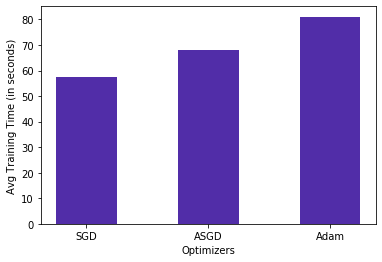

In [89]:
avg_time_sgd = round(all_times['SGD']/3, 3)
avg_time_asgd = round(all_times['ASGD']/3, 3)
avg_time_adam = round(all_times['Adam']/3, 3)

width = 0.5
plt.bar('SGD', avg_time_sgd, width, color=my_colors['purple'])
plt.bar('ASGD', avg_time_asgd, width, color=my_colors['purple'])
plt.bar('Adam', avg_time_adam, width, color=my_colors['purple'])
plt.ylabel('Avg Training Time (in seconds)')
plt.xlabel('Optimizers')
plt.show()

In [0]:
losses_sgd = []
losses_asgd = []
losses_adam = []

scores_sgd = []
scores_asgd = []
scores_adam = []

# SGD -> losses
temp_128 = all_losses['SGD']['128']
temp_64 = all_losses['SGD']['64']
temp_32 = all_losses['SGD']['32']
losses_sgd.append(temp_32)
losses_sgd.append(temp_64)
losses_sgd.append(temp_128)
losses_sgd = np.array(losses_sgd)
# SGD -> scores
temp_128 = all_scores['SGD']['128']
temp_64 = all_scores['SGD']['64']
temp_32 = all_scores['SGD']['32']
scores_sgd.append(temp_32)
scores_sgd.append(temp_64)
scores_sgd.append(temp_128)
scores_sgd = np.array(scores_sgd)


# ASGD -> losses
temp_128 = all_losses['ASGD']['128']
temp_64 = all_losses['ASGD']['64']
temp_32 = all_losses['ASGD']['32']
losses_asgd.append(temp_32)
losses_asgd.append(temp_64)
losses_asgd.append(temp_128)
losses_asgd = np.array(losses_asgd)
# ASGD -> scores
temp_128 = all_scores['ASGD']['128']
temp_64 = all_scores['ASGD']['64']
temp_32 = all_scores['ASGD']['32']
scores_asgd.append(temp_32)
scores_asgd.append(temp_64)
scores_asgd.append(temp_128)
scores_asgd = np.array(scores_asgd)


# Adam -> losses
temp_128 = all_losses['Adam']['128']
temp_64 = all_losses['Adam']['64']
temp_32 = all_losses['Adam']['32']
losses_adam.append(temp_32)
losses_adam.append(temp_64)
losses_adam.append(temp_128)
losses_adam = np.array(losses_adam)
# Adam -> scores
temp_128 = all_scores['Adam']['128']
temp_64 = all_scores['Adam']['64']
temp_32 = all_scores['Adam']['32']
scores_adam.append(temp_32)
scores_adam.append(temp_64)
scores_adam.append(temp_128)
scores_adam = np.array(scores_adam)

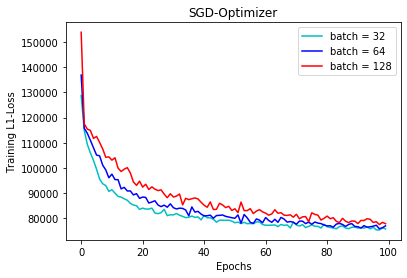

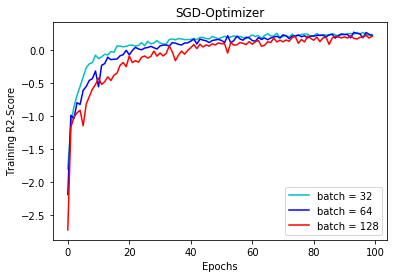

In [110]:
##
## Optimizer : SGD
## 

#
# L1-Loss Comparison
# 
plt.plot(range(max_epochs), losses_sgd[0], color='c', label='batch = 32')
plt.plot(range(max_epochs), losses_sgd[1], color='b', label='batch = 64')
plt.plot(range(max_epochs), losses_sgd[2], color='r', label='batch = 128')
plt.title('SGD-Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Training L1-Loss')
plt.legend(loc='upper right')
plt.show()

print()
print()

#
# R2-Score Comparison
# 
plt.plot(range(max_epochs), scores_sgd[0], color='c', label='batch = 32')
plt.plot(range(max_epochs), scores_sgd[1], color='b', label='batch = 64')
plt.plot(range(max_epochs), scores_sgd[2], color='r', label='batch = 128')
plt.title('SGD-Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Training R2-Score')
plt.legend(loc='lower right')
plt.show()

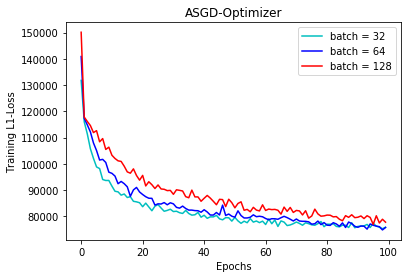

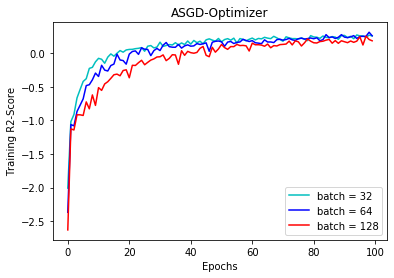

In [109]:
##
## Optimizer : ASGD
##

#
# L1-Loss Comparison
# 
plt.plot(range(max_epochs), losses_asgd[0], color='c', label='batch = 32')
plt.plot(range(max_epochs), losses_asgd[1], color='b', label='batch = 64')
plt.plot(range(max_epochs), losses_asgd[2], color='r', label='batch = 128')
plt.title('ASGD-Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Training L1-Loss')
plt.legend(loc='upper right')
plt.show()

print()
print()

#
# R2-Score Comparison
# 
plt.plot(range(max_epochs), scores_asgd[0], color='c', label='batch = 32')
plt.plot(range(max_epochs), scores_asgd[1], color='b', label='batch = 64')
plt.plot(range(max_epochs), scores_asgd[2], color='r', label='batch = 128')
plt.title('ASGD-Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Training R2-Score')
plt.legend(loc='lower right')
plt.show()

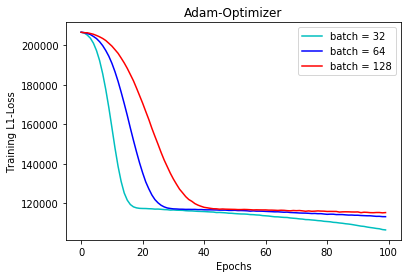

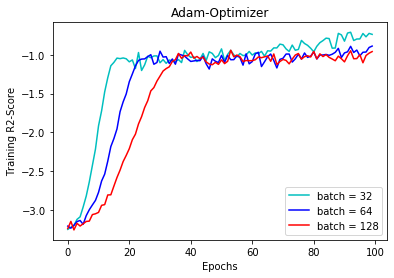

In [98]:
##
## Optimizer : Adam
##

# 
# L1-Loss Comparison
# 
plt.plot(range(max_epochs), losses_adam[0], color='c', label='batch = 32')
plt.plot(range(max_epochs), losses_adam[1], color='b', label='batch = 64')
plt.plot(range(max_epochs), losses_adam[2], color='r', label='batch = 128')
plt.title('Adam-Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Training L1-Loss')
plt.legend(loc='upper right')
plt.show()

print()
print()

# 
# R2-Score Comparison
# 
plt.plot(range(max_epochs), scores_adam[0], color='c', label='batch = 32')
plt.plot(range(max_epochs), scores_adam[1], color='b', label='batch = 64')
plt.plot(range(max_epochs), scores_adam[2], color='r', label='batch = 128')
plt.title('Adam-Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Training R2-Score')
plt.legend(loc='lower right')
plt.show()

In [0]:
# Best performances

# SGD-optimizer
# batch_size = 64

# ASGD-optimizer
# batch_size = 64

# Adam-optimizer
# batch_size = 32

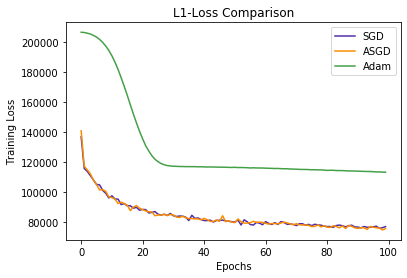

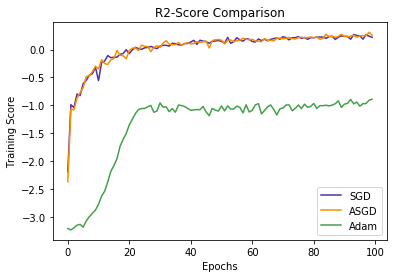

In [107]:
# 
# L1-Loss Comparison
# 
plt.plot(range(max_epochs), losses_sgd[1], color=my_colors['purple'], label='SGD')
plt.plot(range(max_epochs), losses_asgd[1], color=my_colors['orange'], label='ASGD')
plt.plot(range(max_epochs), losses_adam[1], color=my_colors['lgreen'], label='Adam')
plt.title('L1-Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend(loc='upper right')
plt.show()


# 
# R2-Score Comparison
# 
plt.plot(range(max_epochs), scores_sgd[1], color=my_colors['purple'], label='SGD')
plt.plot(range(max_epochs), scores_asgd[1], color=my_colors['orange'], label='ASGD')
plt.plot(range(max_epochs), scores_adam[1], color=my_colors['lgreen'], label='Adam')
plt.title('R2-Score Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Score')
plt.legend(loc='lower right')
plt.show()

In [129]:
# SGD-optimizer (with batch_size = 64) seems to be performing the best out of these
#
# So, we will be taking that  model as the final model, and perform the training and
# testing operation again, and finally save the model weights

#
# This block trains the ConvNet model using the SGD optimizer in PyTorch
#

batch_size = 64
lr = 1e-5
kernel_size = 1

in_data = torch.from_numpy(x_train_np).cuda().float()
out_data = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

test_in_data = torch.from_numpy(x_test_np).cuda().float()
test_out_data = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(in_data, out_data)

# Start tracking time
start = time.time()

# Create CNN model with the given batch_size
cnn_model = ConvNet(X.shape[1], 1, batch_size, kernel_size)
cnn_model.cuda()

# Create an optimizer using the current model's parameters
optimizer = SGD(cnn_model.parameters(), lr=lr)

loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

print('-'*20)
print("Batch Size : " + str(batch_size))
print('-'*20)

for epoch in range(max_epochs):
    loss, score = compute_performance(cnn_model, loader, train=True, optimizer=optimizer)
    _losses.append(loss)
    _scores.append(score)
    
    if((epoch+1) % 10 == 0):
        print("Training Epoch {}\n\tL1-Loss : {}\n\tR2-score : {}".format(epoch+1, loss, score))

test_loss, test_score = compute_performance(cnn_model, loader, train=False, optimizer=optimizer)

print()
print("Testing Loss and Scores")
print()
print("L1-Loss = {}\nR2-Score = {}".format(test_loss, test_score))

stop = time.time()

el_time = round(stop - start, 3)
print()
print('-'*20)
print("Total time elapsed : {} seconds".format(el_time))

# print("...Done...")
print('-'*20)
print()

--------------------
Batch Size : 64
--------------------
Training Epoch 10
	L1-Loss : 96919.36441984306
	R2-score : -0.34788138528821677
Training Epoch 20
	L1-Loss : 88465.58334501121
	R2-score : -0.043068936034193844
Training Epoch 30
	L1-Loss : 85505.38307525225
	R2-score : 0.04322283508429575
Training Epoch 40
	L1-Loss : 83076.69035524104
	R2-score : 0.06505474200802396
Training Epoch 50
	L1-Loss : 82283.66220571748
	R2-score : 0.14115894003873758
Training Epoch 60
	L1-Loss : 79494.77110776346
	R2-score : 0.13856539545109908
Training Epoch 70
	L1-Loss : 79163.27921804933
	R2-score : 0.14479979477952748
Training Epoch 80
	L1-Loss : 78168.64827984865
	R2-score : 0.21840758473117464
Training Epoch 90
	L1-Loss : 75466.66500840808
	R2-score : 0.23077623221717108
Training Epoch 100
	L1-Loss : 76200.5617467769
	R2-score : 0.2358061786351103

Testing Loss and Scores

L1-Loss = 70847.72137752242
R2-Score = 0.36122390692558826

--------------------
Total time elapsed : 53.586 seconds
-------

In [0]:
# Now saving model weights
save_path = '/content/drive/My Drive/1116823_1dconv_reg.pth'

torch.save(cnn_model.state_dict(), save_path)

In [133]:
# Now, we try loading the saved model weights and check if we get the model back
new_model = ConvNet(X.shape[1], 1, batch_size, kernel_size)

new_model.load_state_dict(torch.load(save_path))
new_model.cuda()

new_model.eval()

ConvNet(
  (conv1): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten): Flatten()
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (predictions): Linear(in_features=64, out_features=1, bias=True)
)

In [136]:
new_test_loss, new_test_score = compute_performance(new_model, loader, train=False, optimizer = SGD(new_model.parameters(), lr=lr))
print("New model testing")
print('-'*20)
print("L1-Loss : " + str(new_test_loss))
print()
print("R2-Score : " + str(new_test_score))

New model testing
--------------------
L1-Loss : 70824.28196818946

R2-Score : 0.3696801767643045


In [0]:
# Helper function to count number of trainable model-parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [141]:
print("Number of trainable parameters")
print('='*30)
print("Old saved CNN-model : " + str(count_parameters(cnn_model)))
print('-'*30)
print("New loaded CNN-model : " + str(count_parameters(new_model)))
print('='*30)

Number of trainable parameters
Old saved CNN-model : 17217
------------------------------
New loaded CNN-model : 17217
